<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-libraries" data-toc-modified-id="Load-libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load libraries</a></span></li><li><span><a href="#Load-data" data-toc-modified-id="Load-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load data</a></span></li><li><span><a href="#Train-model" data-toc-modified-id="Train-model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Train model</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Evaluation</a></span></li></ul></div>

# Load libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import evaluation
import _pickle as cPickle

# Load data

In [3]:
data_dir = "./data/"  + "dataset/"

MFCC_LEN_LIM = 700
N_MFCC = 13
FOLDS = 10

In [6]:
X = []
y = []
for fold in range(1, FOLDS):
    with open(data_dir + f"data_mfcc_{fold}.pkl", 'rb') as f:
        data_mfcc = cPickle.load(f)
        
    for i in range(len(data_mfcc['sentence_I'])):
        sentence_I = np.zeros((MFCC_LEN_LIM, N_MFCC), dtype=np.float32)
        sentence_I[-data_mfcc['sentence_I'][i].shape[0]:] = data_mfcc['sentence_I'][i]
        sentence_II = np.zeros((MFCC_LEN_LIM, N_MFCC), dtype=np.float32)
        sentence_II[-data_mfcc['sentence_II'][i].shape[0]:] = data_mfcc['sentence_II'][i]
        X.append([sentence_I, sentence_II])
        y.append(data_mfcc['same_speaker'][i])
X = np.array(X)
y = np.array(y)
X.shape

(90000, 2, 700, 13)

In [7]:
# np.save(data_dir + "data_mfcc_x.npy", X)
# np.save(data_dir + "data_mfcc_y.npy", y)

In [14]:
X = np.load(data_dir + "data_mfcc_x.npy")
y = np.load(data_dir + "data_mfcc_y.npy")

# Train model

In [4]:
from modeling.gru_gru import GRU_GRU

model = GRU_GRU(num_features=N_MFCC)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 13)]   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 13)]   0                                            
__________________________________________________________________________________________________
gru (GRU)                       (None, None, 64)     15168       input_1[0][0]                    
__________________________________________________________________________________________________
gru_2 (GRU)                     (None, None, 64)     15168       input_2[0][0]                    
_______________________________________________________________________________________

In [19]:
model.fit(X, y, epochs=100, early_stopping_rounds=7)

Epoch 1/100
2532/2532 [==============================] - 230s 91ms/step - loss: 0.5275 - acc: 0.7308 - val_loss: 0.3477 - val_acc: 0.8546
Epoch 2/100
2532/2532 [==============================] - 227s 90ms/step - loss: 0.3220 - acc: 0.8694 - val_loss: 0.2485 - val_acc: 0.9023
Epoch 3/100
2532/2532 [==============================] - 227s 90ms/step - loss: 0.2578 - acc: 0.9010 - val_loss: 0.2097 - val_acc: 0.9229
Epoch 4/100
2532/2532 [==============================] - 223s 88ms/step - loss: 0.2166 - acc: 0.9189 - val_loss: 0.1766 - val_acc: 0.9370
Epoch 5/100
2532/2532 [==============================] - 223s 88ms/step - loss: 0.1853 - acc: 0.9322 - val_loss: 0.1559 - val_acc: 0.9440
Epoch 6/100
2532/2532 [==============================] - 223s 88ms/step - loss: 0.1662 - acc: 0.9402 - val_loss: 0.1366 - val_acc: 0.9496
Epoch 7/100
2532/2532 [==============================] - 223s 88ms/step - loss: 0.1510 - acc: 0.9467 - val_loss: 0.1195 - val_acc: 0.9588
Epoch 8/100
2532/2532 [===========

KeyboardInterrupt: 

In [20]:
model.save_weights()

# Evaluation

In [11]:
model.load_weights()

In [6]:
X_test = []
y_test = []
with open(data_dir + f"data_mfcc_0.pkl", 'rb') as f:
    data_mfcc = cPickle.load(f)
        
for i in range(len(data_mfcc['sentence_I'])):
    sentence_I = np.zeros((MFCC_LEN_LIM, N_MFCC), dtype=np.float32)
    sentence_I[-data_mfcc['sentence_I'][i].shape[0]:] = data_mfcc['sentence_I'][i]
    sentence_II = np.zeros((MFCC_LEN_LIM, N_MFCC), dtype=np.float32)
    sentence_II[-data_mfcc['sentence_II'][i].shape[0]:] = data_mfcc['sentence_II'][i]
    X_test.append([sentence_I, sentence_II])
    y_test.append(data_mfcc['same_speaker'][i])
X_test = np.array(X_test)
y_test = np.array(y_test)

In [16]:
y_pred = model.predict(X_test)

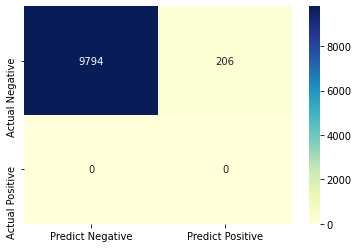

In [17]:
evaluation.plot_confusion_matrix(y_test, y_pred)

In [9]:
evaluation.print_classification_report(y_test, y_pred)

Classification report:
               precision    recall  f1-score   support

       False       1.00      0.98      0.99     10000
        True       0.00      0.00      0.00         0

    accuracy                           0.98     10000
   macro avg       0.50      0.49      0.49     10000
weighted avg       1.00      0.98      0.99     10000



D:\Python\Anaconda3\envs\py3.7\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [10]:
evaluation.get_f1_score(y_test, y_pred, average='binary')

0.0